In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#from plotting_utils import *
#from ml_utils import *
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns;
import scipy
import os

matplotlib.rcParams['figure.dpi']= 150

colors = sns.color_palette("hls", n_colors=11)

In [2]:
'''
Read a json file, return a dict.
'''
def get_data(filename = ''):
    if not os.path.isfile( filename + '.json'):
      print(filename + '.json', 'does not exist.')
      return None
    with open(filename + '.json', 'r') as infile:
        d = json.load(infile)
    #if 'tpu' in filename and 'flops' in d:
    #    d['flops'] = np.multiply(d['flops'] ,8)
    return d

In [3]:
def plot_roofline(f, ax, d, tpu_peak, membdw_peak, \
                  scale='absolute', color_map={}, color_dim='', color=0, thre=1, label='', title=''):

    colormap = {}
    
    d['flops']=np.multiply(d['flops'], 1e-12)
    print("flops *",d['flops'])
    flops=np.multiply(d['flops'], tpu_peak/100)
    
    labels = d['labels']
    intensity = d['arithemetic_intensity']
    if color_dim == '':
        if color == 0:
          ax.plot(d['arithemetic_intensity'], flops, '.', label=label)
        else:
          ax.plot(d['arithemetic_intensity'], flops, '.', label=label, color=color, alpha=0.9)
    else:
        
        hist = {}
        for i in range(len(labels)):
            l = d['labels'][i]
            n = d['batch_size'][i]          
            if intensity[i]<=0 or flops[i]<=0:
              continue
            if not n in hist:
                hist[n] = 0    
            hist[n] += 1
        for k,v in iter(hist.items()):
            hist[k] = v*1.0/len(labels)
        
        m = {}
        mycolors = sns.color_palette("hls", n_colors=len(hist)+2)
        for i in range(len(labels)):
            #if time[i] < thre:
            #  continue
            if intensity[i]<=0 or flops[i]<=0:
              continue
            l = labels[i]
            n = d['batch_size'][i]
                    
            if color_map != {}:
                if n in color_map:
                    if n in m:
                      ax.plot(intensity[i], flops[i], '.', color=color_map[n], marker='.')
                    else:
                      ax.plot(intensity[i], flops[i], '.', color=color_map[n], marker='.', label = n)
                      m[n] = 1
                continue    
            if n in m:
                ax.plot(intensity[i], flops[i], '.',
                        color=mycolors[m[n]], marker='.')
            elif not n in m:
                
                m[n] = len(m) % len(colors)
                colormap[n] = mycolors[m[n]]
                ax.plot(intensity[i], flops[i], '.',
                        color=mycolors[m[n]], label = n, 
                        #markeredgecolor='black', markeredgewidth=0.5, 
                        marker='.')

        ax.legend(frameon=True, bbox_to_anchor=(1, 0.5))

    x1 = tpu_peak / membdw_peak
    y1 = tpu_peak
      
    if max(d['arithemetic_intensity']) > x1:
        if color == 0:
            ax.hlines(y=y1, xmin=x1, 
                xmax=max(d['arithemetic_intensity']), linewidth=2, color=colors[0])
        else:
            ax.hlines(y=y1, xmin=x1, 
                xmax=max(d['arithemetic_intensity']), linewidth=2, color=color)
    
    #x2 = min(d['flops_perc'])*(tpu_peak/100)/membdw_peak
    #y2 = min(d['flops_perc'])*(tpu_peak/100)
    x2 = min(d['flops'])*(tpu_peak/100)/membdw_peak
    y2 = min(d['flops'])*(tpu_peak/100)

    if scale == 'relative':
        y1 = 100
        y2 = x2 * membdw_peak / tpu_peak * 100
    if color == 0:
        ax.plot([x1, x2], [y1, y2], linewidth=2, color=colors[0])
    else:
        ax.plot([x1, x2], [y1, y2], linewidth=2, color=color)
        
    ax.set_yscale('log')
    ax.set_xscale('log')
    if scale == 'absolute':
      ax.set_ylabel('GFLOPS', fontsize=15)
    else:
      ax.set_ylabel('FLOPS %', fontsize=15)
      ax.set_ylim(top=100)
    ax.set_xlabel('Floating Ops/Byte', fontsize=15)
    ax.set_title(title, fontsize=15)

    if colormap == {}:
        colormap = color_map
    return f, ax, colormap

flops * [39.29458576 63.36367684 58.41648871 77.76229175 60.07310158 39.30649659
 81.77376282 65.77494975 60.32799738 72.48586372 70.88565009 59.48734662
 60.03655607 63.21304257 35.15761934 36.1272568  79.06602552 36.82156833
 47.34979615 75.79496493 81.39538308 48.41071184 58.56132598 75.45281371
 19.71377996 70.34914535 43.18681875 64.64710192 48.71999262 60.4519024
 83.3396336  37.36906701 42.29194675 69.77496468 63.69965865 73.10413529
 67.16528039 81.00923797 77.76658191 69.31015609 75.63181443 57.98844271
 61.63222255 36.39421532 48.36605217 65.2365728  76.37985033 45.45685401
 62.48206727 52.26002495 82.81032226 64.71692418 65.06578603 84.29808775
 39.6659662  78.01700065 65.69381811 19.46132128 51.77513599 39.06402149
 51.05043716 80.0449249  83.029321   70.34361282 74.91166246 36.99078226
 74.17321591 64.61100049 82.28751917 80.81596256 54.05901644 83.08766043
 72.38344694 72.01139729 47.57604316 68.99062412 84.36925523 77.34398752
 15.90920922 74.75311977 65.77623703 35.9274

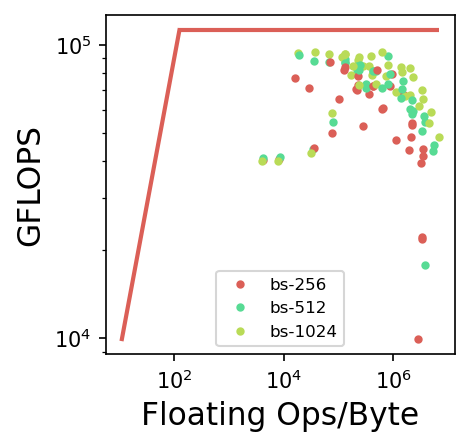

In [6]:
color_dim = 'bs'
d = get_data('v100_linear')


f, ax = plt.subplots(figsize=(3,3))
f, ax, m = plot_roofline(f, ax, d, tpu_peak=112e3, membdw_peak=900, color_dim=color_dim, title='')

# sort the legend
handles, ls = ax.get_legend_handles_labels()
ls = [int(i) for i in ls if i.isdigit()] 
ls, handles = zip(*sorted(zip(ls, handles), key=lambda t: t[0]))
ls = [color_dim + '-' + str(i) for i in ls]
ax.legend(handles, ls, frameon=True, fontsize=8)